# Topological Image Modification and Processing

In this script, we show how to use Topological Image Modification (TIM) and Topological Image Processing (TIP) to improve a variety of generic unsupervised models for skin lesion  segmentation.

We start by importing the necessary packages.

In [1]:
import TDAimgprocess as TIP # topological image modification and processing
import os # os independent path construction 
import time # tracking computation time
import random # setting seeds
import numpy as np # handling arrays and general math
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # handling images
import PIL # imaging library
from skimage.segmentation import chan_vese # chan_vese segmentation
from skimage.segmentation import slic # k-means clustering based oversegmentation
from skimage.filters import roberts # Roberts' cross operator for edge detection
from skimage.morphology import convex_hull_image # construct convex hull of a binary image
import skimage.filters as filters # infer ISODATA thresholds from images
from skimage.segmentation import active_contour # active contour segmentation 
import cv2 # binarize images

%matplotlib inline

## Topological Image Modification and Processing

We start by loading the example image and ground truth segmentation.

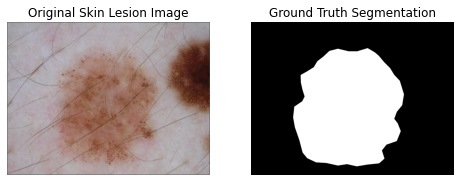

In [2]:
img = mpimg.imread(os.path.join("Image", "input.jpg"))
sgm_truth = mpimg.imread(os.path.join("Image", "groundtruth.png"))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(img)
ax[0].set_axis_off()
ax[0].set_title("Original Skin Lesion Image", fontsize=12)

ax[1].imshow(sgm_truth, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Ground Truth Segmentation", fontsize=12)

plt.show()

Converting to grayscale and adding a small amount of noise is performed prior to conducting TIM and TIP. The random noise not affect the performance of any of our models.

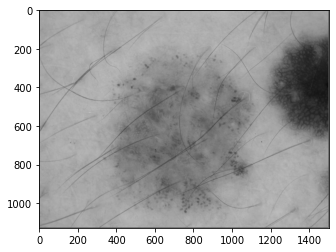

In [3]:
random.seed(42)

img_gray = np.asarray(PIL.Image.fromarray((img).astype(np.uint8)).convert("L")).copy().astype("float") # grayscale
img_gray += 0.01 * np.random.randn(*img_gray.shape) # random noise

plt.imshow(img_gray, cmap="gray")

TIM and TIP can be easily conducted through the following function. It requires two hyperparameters: the window size used to smooth the image, and the width the border to be added to the image. Manually, we always set both values to 25, which most often suffices. Our method is also robust against these values. However, for higher-resolution images, these values (especially the window size) should be increased. Hence, for our large scale experiments, we maintained the ratio between these values and the diameter of the image, as discussed in the main paper. The complete process takes a matter of seconds, and can most often be computed locally. However, for some higher-resolution images, local memory may be infuccient to compute persistent homology.

In [4]:
window_size = 25
border_width = 25

start_time = time.time()
TIP_img = TIP.topological_process_img(img_gray, window_size=window_size, border_width=border_width)
elapsed_time = time.time() - start_time
print("Time for Topological Image Processing: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Time for Topological Image Processing: 00:00:10


We can now visualize the different steps of TIP as follows.

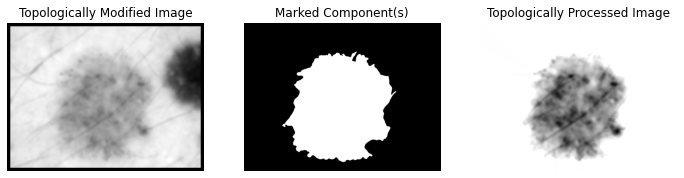

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes.flatten()

ax[0].imshow(TIP_img["modified"], cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Topologically Modified Image", fontsize=12)

ax[1].imshow(TIP_img["components"], cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Marked Component(s)", fontsize=12)

ax[2].imshow(TIP_img["processed"], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Topologically Processed Image", fontsize=12)

plt.show()

Below, we show how to different unsupervised models are improved through TIP.

## Chan-Vese Segmentation

The Chan-Vese segmentation can be quite slow, especially for larger images. We advise not to compute it locally on a large scale, e.g., for all ISIC 2018 images.

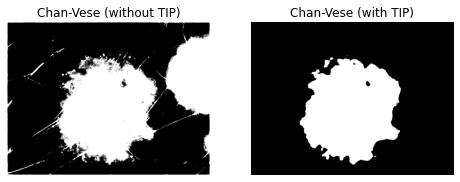

metrics without TIP:
{'accuracy': 0.8083610519571076, 'mcc': 0.573126190611029, 'dice': 0.7173636613151467, 'inclusion': 0.7386772607914828}

metrics with TIP:
{'accuracy': 0.911879511147127, 'mcc': 0.8045562838926004, 'dice': 0.8454992080324304, 'inclusion': 0.732350479025207}


In [6]:
# We conduct the Chan-Vese segmentation algorithm using the standard settings
sgm_without_TIP = chan_vese(img_gray)
sgm_with_TIP = chan_vese(TIP_img["processed"])

# We plot the different segmentations
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(sgm_without_TIP, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Chan-Vese (without TIP)", fontsize=12)

ax[1].imshow(sgm_with_TIP, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Chan-Vese (with TIP)", fontsize=12)

plt.show()

# We evaluate the Segmentations before and after TIP
print("\033[1mmetrics without TIP:\033[0m")
metrics_without_TIP = TIP.get_metrics(sgm_without_TIP, sgm_truth)
print(metrics_without_TIP)
metrics_with_TIP = TIP.get_metrics(sgm_with_TIP, sgm_truth)
print("\n\033[1mmetrics with TIP:\033[0m")
print(metrics_with_TIP)

## ISODATA Segmentation

ISODATA based threshold segmentation is significantly faster, and can easily be computed for all ISIC 2018 skin lesion images, before and after TIP, locally.

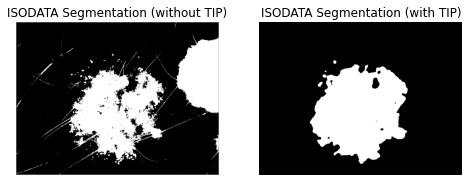

metrics without TIP:
{'accuracy': 0.7510329702429188, 'mcc': 0.4086478825611348, 'dice': 0.5741189223168737, 'inclusion': 0.5097003498780077}

metrics with TIP:
{'accuracy': 0.8799646175301057, 'mcc': 0.7341424071927491, 'dice': 0.7770687818419262, 'inclusion': 0.6354149524552278}


In [7]:
# We apply ISODATA based threshold based segmentation, using the standard settings to select the threshold
sgm_without_TIP = img_gray < filters.threshold_isodata(img_gray)
sgm_with_TIP = TIP_img["processed"] < filters.threshold_isodata(TIP_img["processed"])

# We plot the different segmentations
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(sgm_without_TIP, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("ISODATA Segmentation (without TIP)", fontsize=12)

ax[1].imshow(sgm_with_TIP, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("ISODATA Segmentation (with TIP)", fontsize=12)

plt.show()

# We evaluate the Segmentations before and after TIP
print("\033[1mmetrics without TIP:\033[0m")
metrics_without_TIP = TIP.get_metrics(sgm_without_TIP, sgm_truth)
print(metrics_without_TIP)
metrics_with_TIP = TIP.get_metrics(sgm_with_TIP, sgm_truth)
print("\n\033[1mmetrics with TIP:\033[0m")
print(metrics_with_TIP)

## Isocontour Segmentation

Isocontour is also significantly faster than Chan-Vese segmentation, and can easily be computed for all ISIC 2018 skin lesion images, before and after TIP, locally.

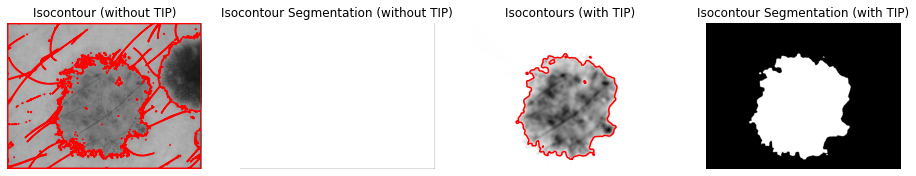

metrics without TIP:
{'accuracy': 0.3307889913875959, 'mcc': 0.027609759371779643, 'dice': 0.4959575237254567, 'inclusion': 1.0}

metrics with TIP:
{'accuracy': 0.9306838098109794, 'mcc': 0.8458860414058497, 'dice': 0.8823475315972347, 'inclusion': 0.7894650229316772}


In [8]:
# We apply isocontour segmentation using the mean of the image as isovalue for the contours
sgm_without_TIP, contours_without_TIP = TIP.contour_segmentation(img_gray, return_contours=True)
sgm_with_TIP, contours_with_TIP = TIP.contour_segmentation(TIP_img["processed"], return_contours=True)

# We plot the different segmentations
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
ax = axes.flatten()

ax[0].imshow(img_gray, cmap="gray")
for contour in contours_without_TIP:
    ax[0].plot(contour[:,1], contour[:,0], color="red")
ax[0].set_axis_off()
ax[0].set_title("Isocontour (without TIP)", fontsize=12)

ax[1].imshow(sgm_without_TIP, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Isocontour Segmentation (without TIP)", fontsize=12)

ax[2].imshow(TIP_img["processed"], cmap="gray")
for contour in contours_with_TIP:
    ax[2].plot(contour[:,1], contour[:,0], color="red")
ax[2].set_axis_off()
ax[2].set_title("Isocontours (with TIP)", fontsize=12)

ax[3].imshow(sgm_with_TIP, cmap="gray")
ax[3].set_axis_off()
ax[3].set_title("Isocontour Segmentation (with TIP)", fontsize=12)

plt.show()

# We evaluate the Segmentations before and after TIP
print("\033[1mmetrics without TIP:\033[0m")
metrics_without_TIP = TIP.get_metrics(sgm_without_TIP, sgm_truth)
print(metrics_without_TIP)
metrics_with_TIP = TIP.get_metrics(sgm_with_TIP, sgm_truth)
print("\n\033[1mmetrics with TIP:\033[0m")
print(metrics_with_TIP)

## k-Means Clustering Based Oversegmentation.

We illustrate how TIP improves k-means clustering based oversegmentation as well. This method is not evaluated as a binary segmentation model.

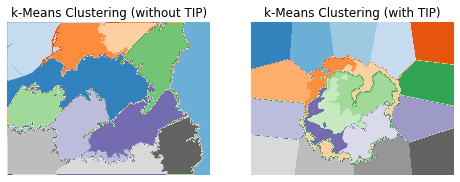

In [9]:
# We segment the images in 20 superpixels with and without TIP
sgm_without_TIP = slic(img_gray, start_label=1, n_segments=20)
sgm_with_TIP = slic(TIP_img["processed"], start_label=1, n_segments=20)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(sgm_without_TIP, cmap="tab20c")
ax[0].set_axis_off()
ax[0].set_title("k-Means Clustering (without TIP)", fontsize=12)

ax[1].imshow(sgm_with_TIP, cmap="tab20c")
ax[1].set_axis_off()
ax[1].set_title("k-Means Clustering (with TIP)", fontsize=12)

plt.show()

## Edge Detection

We illustrate how TIP improves edge detection in images. For this, we use Roberts' cross operator, which requires no hyperparameters. Again, this method is not evaluated as a binary segmentation model.

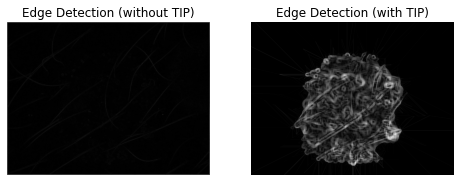

In [10]:
sgm_without_TIP = roberts(img_gray)
sgm_with_TIP = roberts(TIP_img["processed"])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(sgm_without_TIP, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Edge Detection (without TIP)", fontsize=12)

ax[1].imshow(sgm_with_TIP, cmap="gray")
ax[1].set_axis_off()
ax[1].set_title("Edge Detection (with TIP)", fontsize=12)

plt.show()

## Active Contour Segmentation

We illustrate how our method can be used for active contour segmentation. For this, we use Roberts' cross operator, which requires no hyperparameters. Again, this method is not evaluated as a binary segmentation model. The convex hull of the marked component(s) is used as initialization of the segmentation algorithm. Though this does result in a segmentation algorith, we do not compare it to a segmentation prior to TIP. The reason for this, is that we cannot produce an effective initialization that produces consistent results on a large scale for these images, prior to our work. 

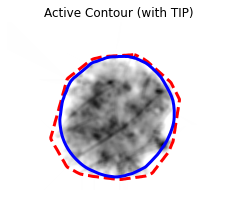

In [11]:
# We initialize the snake through the convex hull of our marked component(s)
init = cv2.findContours(np.uint8(convex_hull_image(TIP_img["components"])), 
                        cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
init = init[0].reshape([init[0].shape[0], init[0].shape[2]])
init = init[range(init.shape[0])[::10],:][:,[1,0]]

# We conduct active contour segmentation of our topologically processed image
# The used settings are found on https://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html
snake = active_contour(TIP_img["processed"], init, coordinates="rc", alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.imshow(TIP_img["processed"], cmap="gray")
ax.plot(init[:,1], init[:,0], "--r", lw=3)
ax.plot(snake[:,1], snake[:,0], "-b", lw=3)
ax.set_axis_off()
ax.set_title("Active Contour (with TIP)", fontsize=12)

plt.subplots_adjust(wspace=0.1, hspace=-0.3)
plt.show()